**Import dataset**

In [ ]:
!git clone https://github.com/aqiff12/ml_assignment.git

Cloning into 'ml_assignment'...
remote: Enumerating objects: 1469, done.
remote: Total 1469 (delta 0), reused 0 (delta 0), pack-reused 1469
Receiving objects: 100% (1469/1469), 74.32 MiB | 23.40 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Checking out files: 100% (1441/1441), done.


**Import libraries**

In [ ]:
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
from sklearn.decomposition import PCA

# Visualization
import plotly.offline as py
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import plotly.graph_objs as go
import plotly.tools as tls
import librosa.display
import glob
from google.colab import drive
import shutil
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

## **First data**

**Frequency & Spectrogram graph**

Text(0.5, 0, 'Seconds')

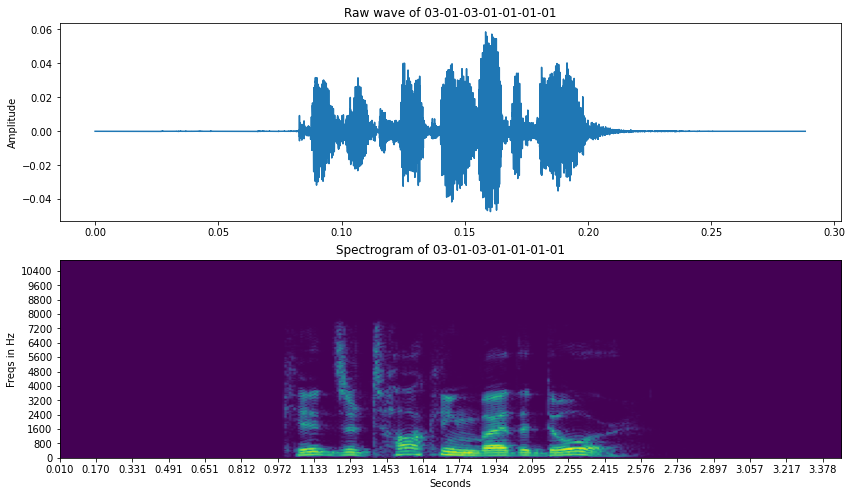

In [ ]:
filename = './ml_assignment/ML_dataset/Actor_01/03-01-03-01-01-01-01.wav'
samples,sample_rate = librosa.load(filename)
newFilename = filename[36:-4]
freqs, times, spectrogram = log_specgram(samples, sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + newFilename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), len(samples)), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + newFilename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

**Calculate the mean, standard deviation and spectrogram**

In [ ]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

**Mel Spectrogram graph**

In [ ]:
def sentenceSaid (newFilename):
  k = newFilename.split("-")
  if k[4] == '01':
      sentence = "Kids are talking by the door"
  else:
      sentence = "Dogs are sitting by the door"
  return sentence

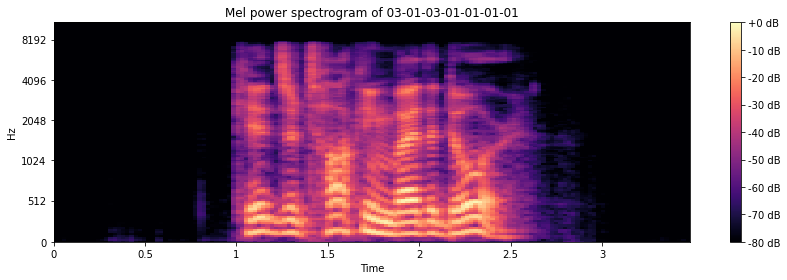

In [ ]:
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram of '+newFilename)
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [ ]:
sentenceSaid(newFilename)

'Kids are talking by the door'

**Mel Frequency cepstral coefficients**

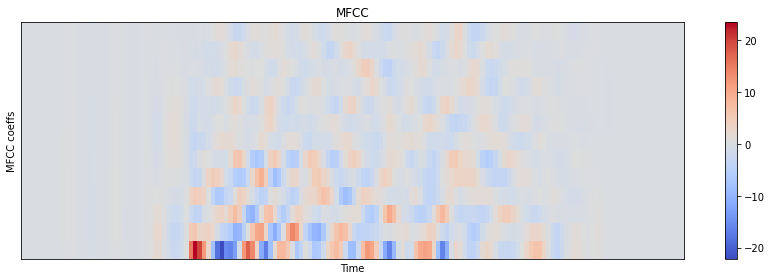

In [ ]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

To get the words said by the wav file based on the file name

**Spectrogram of the sentence in 3D**

In [ ]:
data = [go.Surface(x=times, y=freqs, z=spectrogram.T)]
layout = go.Layout(
title='Specgtrogram of "{}" in 3d'.format(sentenceSaid(newFilename)),
scene = dict(
yaxis = dict(title='Frequncy', range=[freqs.min(),freqs.max()]),
xaxis = dict(title='Time', range=[times.min(),times.max()],),
zaxis = dict(title='Log amplitude'),
),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

**Silence removal**

Original sound file


In [ ]:
ipd.Audio(samples, rate=sample_rate)

Edited soundfile

In [ ]:
samples_cut = samples[20000:55000]
ipd.Audio(samples_cut, rate=sample_rate)

**View for each characters in frequency and spectrogram graph**

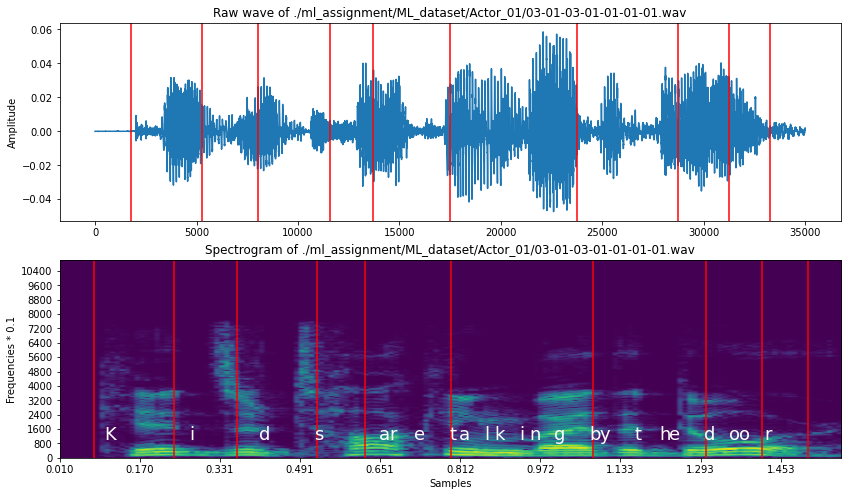

In [ ]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)
initialTime = 0.10
initialGap = 0.17
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
for i in sentenceSaid(newFilename):
    ax2.text(initialTime, 1000, i, fontsize=18,color='white')
    initialTime = initialTime + initialGap
    initialGap= initialGap - 0.03
    if initialGap < 0:
        initialGap = 0.05
    

xcoords = [0.050, 0.150,0.23,0.331, 0.392,0.500,0.679, 0.821,0.892,0.950]
for xc in xcoords:
    ax1.axvline(x=xc*samples_cut.shape[0], c='r')
    ax2.axvline(x=(xc*samples_cut.shape[0])/sample_rate, c='r')

## **Second data**

**Frequency & Spectrogram graph**

Text(0.5, 0, 'Seconds')

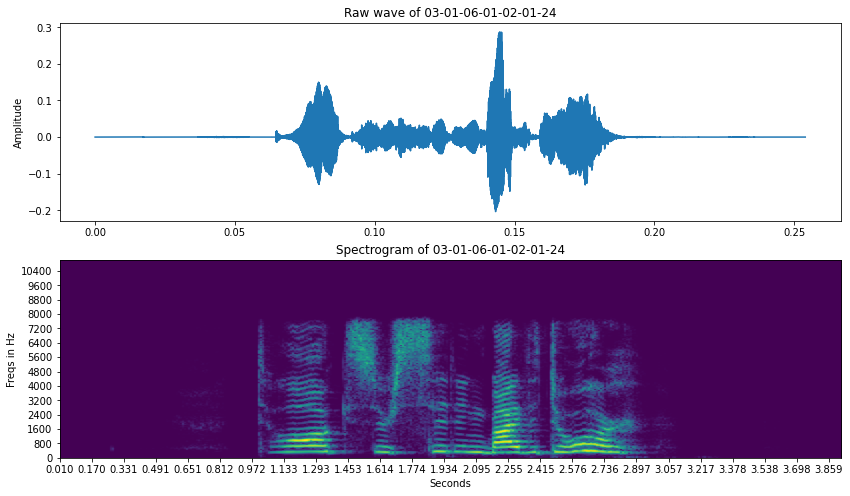

In [ ]:
filename = './ml_assignment/ML_dataset/Actor_24/03-01-06-01-02-01-24.wav'
samples,sample_rate = librosa.load(filename)
newFilename = filename[36:-4]
freqs, times, spectrogram = log_specgram(samples, sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + newFilename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), len(samples)), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + newFilename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

**Calculate the mean, standard deviation and spectrogram**

In [ ]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

**Mel Spectrogram graph**

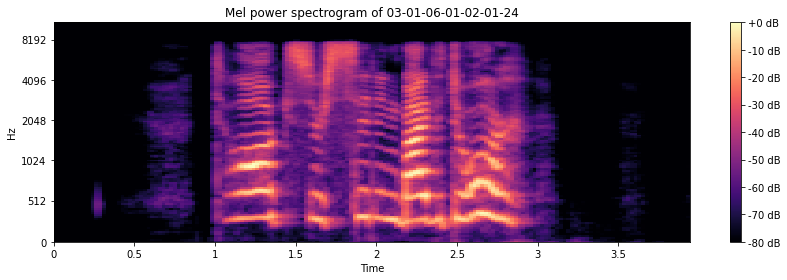

In [ ]:
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram of '+newFilename)
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [ ]:
sentenceSaid(newFilename)

'Dogs are sitting by the door'

**Mel Frequency cepstral coefficients**

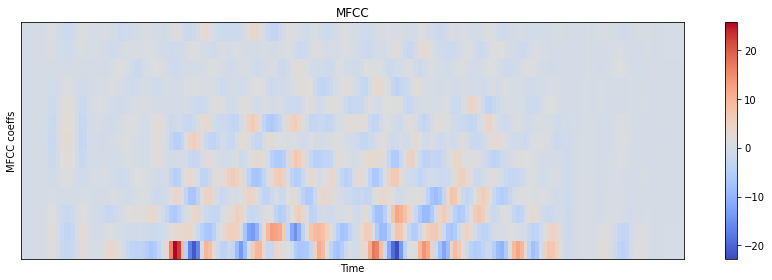

In [ ]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

**Spectrogram of the sentence in 3D**

In [ ]:
data = [go.Surface(x=times, y=freqs, z=spectrogram.T)]
layout = go.Layout(
title='Specgtrogram of "{}" in 3d'.format(sentenceSaid(newFilename)),
scene = dict(
yaxis = dict(title='Frequncy', range=[freqs.min(),freqs.max()]),
xaxis = dict(title='Time', range=[times.min(),times.max()],),
zaxis = dict(title='Log amplitude'),
),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

**Silence removal**

Original sound file

In [ ]:
ipd.Audio(samples, rate=sample_rate)

Edited soundfile

In [ ]:
samples_cut = samples[20000:64000]
ipd.Audio(samples_cut, rate=sample_rate)

**View for each characters in frequency and spectrogram graph**

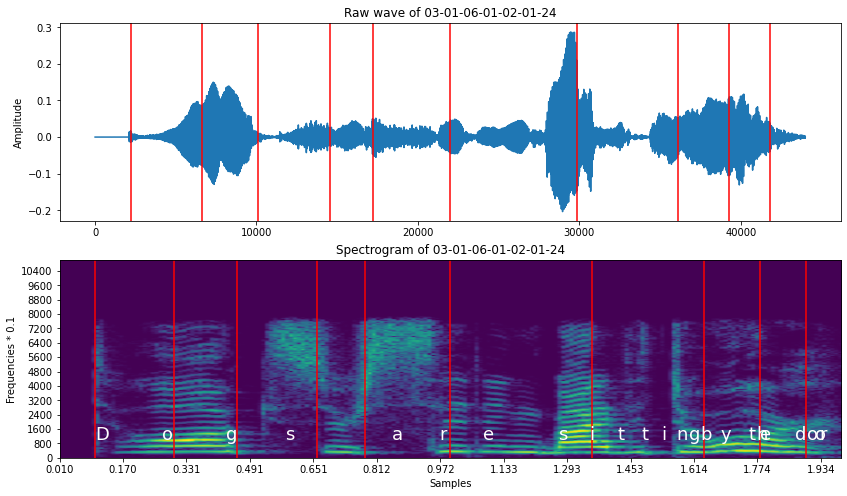

In [ ]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)
initialTime = 0.10
initialGap = 0.17
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + newFilename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + newFilename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
for i in sentenceSaid(newFilename):
    ax2.text(initialTime, 1000, i, fontsize=18,color='white')
    initialTime = initialTime + initialGap
    initialGap= initialGap - 0.01
    if initialGap < 0:
        initialGap = 0.05
    

xcoords = [0.050, 0.150,0.23,0.331, 0.392,0.500,0.679, 0.821,0.892,0.950]
for xc in xcoords:
    ax1.axvline(x=xc*samples_cut.shape[0], c='r')
    ax2.axvline(x=(xc*samples_cut.shape[0])/sample_rate, c='r')

## Dataset Investigation

### Number of actors

In [ ]:
actorsGlobPath = './ml_assignment/ML_dataset/Actor_*'
actorDirs = [f for f in glob.glob(actorsGlobPath)]
actorDirs.sort()
print('Number of actors: '+ str(len(actorDirs)))

Number of actors: 24


### Number of audios

In [ ]:
audioGlobPath = './ml_assignment/ML_dataset/Actor_*/*.wav'
audioDirs = [f.split('/')[3] + '/' + f.split('/')[4] for f in glob.glob(audioGlobPath)]
filenames = [f.split('/')[1].replace('.wav', '') for f in audioDirs]
audioDirs.sort()
filenames.sort()
print('Number of audios: ' + str(len(audioDirs)))

Number of audios: 1440


### Filename identifiers


* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).



In [ ]:
emotions1 = []
emotions2 = []
statement1Dirs = []
statement2Dirs = []


for i in range(len(audioDirs)):
  filename_identifier = filenames[i].split('-')
  statement = filename_identifier[4]
  emotion = int(filename_identifier[2].replace('0',''))
  if statement == '01':
    statement1Dirs.append(audioDirs[i])
    emotions1.append(emotion)
  elif statement == '02':
    statement2Dirs.append(audioDirs[i])
    emotions2.append(emotion)

print(emotions1)
print(statement1Dirs)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [ ]:
def plot_graph(title, emotions):
  type_of_emotions = ['neutral', 'calm', 'happy', 'sad', 'angry','fearful', 'disgust', 'surprised']
  number_of_emotions = [0 for x in type_of_emotions]

  for emotion in emotions:
    number_of_emotions[emotion-1] += 1

  data = [go.Histogram(x=type_of_emotions, y=number_of_emotions)]
  trace = go.Bar(
      x = type_of_emotions,
      y = number_of_emotions,
      # marker = dict(color = number_of_emotions, colorscale= 'Viridius', showscale=True),
  )
  layout = go.Layout(
      title = 'Number of emotions for statement '+ title,
      xaxis = dict(title = "Emotions"),
      yaxis = dict(title="Number of emotions")
  )

  py.iplot(go.Figure(data=[trace], layout=layout))

In [ ]:
plot_graph('"Kids are talking by the door"',emotions1)
plot_graph('"Dogs are sitting by the door"',emotions2)

## Deeper into recordings

There's a very important fact. Recordings come from very different sources. As far as I can tell, some of them can come from mobile GSM channel.

Nevertheless, it is extremely important to split the dataset in a way that one speaker doesn't occur in both train and test sets. Just take a look and listen to this two examples:


In [ ]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

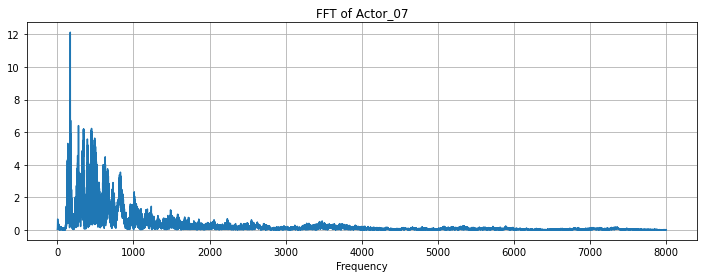

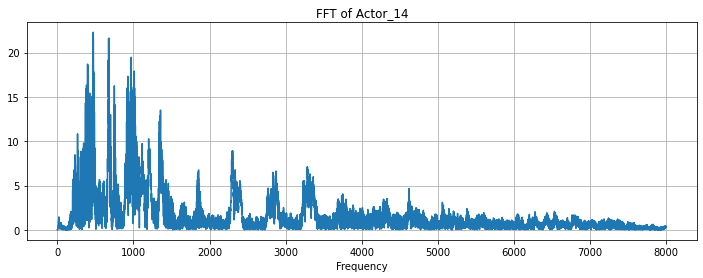

In [ ]:
audio_path = './ml_assignment/ML_dataset/'
filenames = ['Actor_07/03-01-04-01-01-01-07.wav', 'Actor_14/03-01-05-01-01-01-14.wav']

for filename in filenames:
  sample_rate, samples = wavfile.read(audio_path+filename)
  xf, vals = custom_fft(samples, sample_rate)
  plt.figure(figsize=(12,4))
  plt.title('FFT of ' + filename.split('/')[0])
  plt.plot(xf, vals)
  plt.xlabel('Frequency')
  plt.grid()
  plt.show

In [ ]:
print(filenames[0].split('/')[0])
ipd.Audio(audio_path + filenames[0])

In [ ]:
print(filenames[1].split('/')[0])
ipd.Audio(audio_path + filenames[1])

# Machine Learning Processes - 
1. Feature Extraction
2. Pre-processing Data
3. Train Models
4. Models Evaluation/Comparisons

In [ ]:
## Install package to handle speech
!pip install soundfile
!pip install librosa --upgrade

Requirement already up-to-date: librosa in /usr/local/lib/python3.6/dist-packages (0.7.2)


## 1. Import all the required libraries



In [ ]:
## Import Required Libraries

# Import Sklearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# Import Others
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from scipy.io import wavfile
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

pd.set_option('display.max_rows', 500)


## 2. Data preprocessing and preparation
In this step, we are going to get all the audio file into a list.

In [ ]:
path = '/content/ml_assignment/ML_dataset'
files = [file for file in glob.glob(path + "//Actor_*//*.wav")]

## 3. Features extraction


In [ ]:
def extract_feature(file_name, mfcc, chroma, mel=False, cqt=False ,
                    spectral=False, tonnetz=False, tempogram=False,rms=False, poly_features=False, zero_crossing_rate=False):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """    
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
        if cqt:
            cqt = np.mean(librosa.feature.chroma_cqt(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, cqt))
        if spectral:
            spectral = np.mean(librosa.feature.spectral_contrast(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, spectral))
        if tempogram:
            tempogram = np.mean(librosa.feature.tempogram(X,  sr=sample_rate).T,axis=0)
            result=np.hstack((result, tempogram))
        if rms:
            rms = np.mean(librosa.feature.rms(X).T ,axis=0) #1 feature
            result=np.hstack((result, rms))
        if poly_features:
            poly_features = np.mean(librosa.feature.poly_features(X, sr=sample_rate).T,axis=0) #1 feature
            result=np.hstack((result, poly_features))
        if zero_crossing_rate:
            zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(X).T, axis = 0) #2 feature
            result=np.hstack((result, zero_crossing_rate))
        
    return result

For the baseline model, we are using MFCC, Chroma and Mel Frequency Cepstrum as the feautures.

## 4. Define the target label.

Let’s define a dictionary to hold numbers and the emotions available in the RAVDESS dataset.

Emotions that we want predict: 
* calm
* happy
* fearful
* disgust





In [ ]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

observed_emotions=['calm', 'happy', 'fearful', 'disgust']

#5. Load and split the data into train and test set.
Let’s keep the test set 25% of everything and use the load_data function for this.

In [ ]:

def load_data(path, test_size=0.2,boolean_feature = None):
  '''
  This function is used to load the audio file.

  Return train test split data
  '''
  x,y=[],[]
    
  for index , file in enumerate(glob.glob(path + "//Actor_*//*.wav")): #change slash to backslash suit the path in colab
      file_name=os.path.basename(file)
      emotion=emotions[file_name.split("-")[2]]
      if emotion not in observed_emotions:
          continue
      if boolean_feature is None:
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
      else:
        print('Features select')
        feature=extract_feature(file, *boolean_feature)
      # print(index)

      
      x.append(feature)
      y.append(emotion)

  return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [ ]:
x_train,x_test,y_train,y_test=load_data(path, test_size=0.25)

# 6. Train and test the model
---
The model that we are going to use to predict emotion are:
- MLP Classifier
- gradientBoosting
- xgboost

The features we used to fit in these models are MFCC, Mel and Chroma.


Obeserved the number of features

In [ ]:
print(f'Features extracted: {x_train.shape[1]}')


Features extracted: 180


## Add dimensionality reduction.

There are 180 features extracted using MFCC, Mel and Chroma methods. 

We are going to use Principal Component Analysis (PCA) to reduce the features.

We'll be reducing it into 170 features, 10 features less than orginal.


In [ ]:
## Combine the train and test data
X = np.concatenate((x_train,x_test))
Y = np.concatenate((y_train,y_test))

## Initialise PCA
## Reduce the features from 180 to 170
pca = PCA(n_components=170,svd_solver='full')
X_pca = pca.fit_transform(X)

## Get the reduced train and test data
x_train_reduce,x_test_reduce,y_train_reduce,y_test_reduce = train_test_split(np.array(X_pca), Y, test_size=0.25, random_state=9)

## 1. Multi Layer Perceptron (MLP) Classifier

In [ ]:
## Initialize the model
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

## Train the model
model.fit(x_train,y_train)

## Make Prediction
y_pred=model.predict(x_test)

## Calculate Accuracy
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 74.48%


With PCA

In [ ]:
model.fit(x_train_reduce,y_train_reduce)
y_pred=model.predict(x_test_reduce)

accuracy=accuracy_score(y_true=y_test_reduce, y_pred=y_pred)
print("Confusion Matrix:\n",confusion_matrix(y_true=y_test_reduce, y_pred=y_pred))
print("Accuracy: {:.2f}%".format(accuracy*100))

Confusion Matrix:
 [[45  2  4  1]
 [ 3 38  3  8]
 [ 1  4 32  5]
 [ 2  7  7 30]]
Accuracy: 75.52%


In [ ]:
titles_options = [("Confusion matrix, without normalization", None),("Normalized confusion matrix",'true')]

for title, normalize in titles_options:
  disp = plot_confusion_matrix(model, x_test_reduce, y_test_reduce, display_labels = ['calm', 'happy', 'fearful', 'disgust'], cmap = plt.cm.Blues, normalize = normalize)

  disp.ax_.set_title(title)

  print(title)
  print(disp.confusion_matrix)

plt.show()

Confusion matrix, without normalization
[[46  2  4  0]
 [ 5 38  2  7]
 [ 0  4 33  5]
 [ 3  3  8 32]]
Normalized confusion matrix
[[0.88461538 0.03846154 0.07692308 0.        ]
 [0.09615385 0.73076923 0.03846154 0.13461538]
 [0.         0.0952381  0.78571429 0.11904762]
 [0.06521739 0.06521739 0.17391304 0.69565217]]


## 2. Gradient Boosting

In [ ]:
## Initialize the model
model=GradientBoostingClassifier()

## Train the model
model.fit(x_train,y_train)

## Make Prediction
y_pred=model.predict(x_test)

## Calculate Accuracy
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 73.44%


With PCA

In [ ]:
model.fit(x_train_reduce,y_train_reduce)
y_pred=model.predict(x_test_reduce)

accuracy=accuracy_score(y_true=y_test_reduce, y_pred=y_pred)
print("Confusion Matrix:\n",confusion_matrix(y_true=y_test_reduce, y_pred=y_pred))
print("Accuracy: {:.2f}%".format(accuracy*100))

Confusion Matrix:
 [[43  6  2  1]
 [ 4 35  4  9]
 [ 3  9 26  4]
 [ 5 11  9 21]]
Accuracy: 65.10%


Confusion matrix, without normalization
[[43  6  2  1]
 [ 4 35  4  9]
 [ 3  9 26  4]
 [ 5 11  9 21]]
Normalized confusion matrix
[[0.82692308 0.11538462 0.03846154 0.01923077]
 [0.07692308 0.67307692 0.07692308 0.17307692]
 [0.07142857 0.21428571 0.61904762 0.0952381 ]
 [0.10869565 0.23913043 0.19565217 0.45652174]]


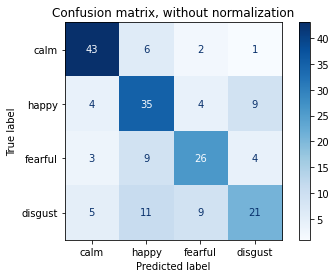

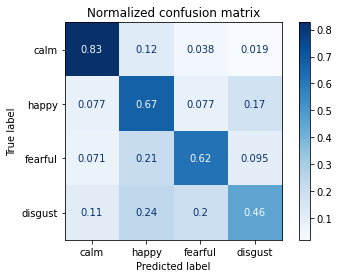

In [ ]:
titles_options = [("Confusion matrix, without normalization", None),("Normalized confusion matrix",'true')]

for title, normalize in titles_options:
  disp = plot_confusion_matrix(model, x_test_reduce, y_test_reduce, display_labels = ['calm', 'happy', 'fearful', 'disgust'], cmap = plt.cm.Blues, normalize = normalize)

  disp.ax_.set_title(title)

  print(title)
  print(disp.confusion_matrix)

plt.show()

## 3. XGboost

In [ ]:
## Initialize the model
model = XGBClassifier()

## Train the model
model.fit(x_train,y_train)

## Make Prediction
y_pred=model.predict(x_test)

## Calculate Accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 73.96%


With PCA

In [ ]:
model.fit(x_train_reduce,y_train_reduce)
y_pred=model.predict(x_test_reduce)

accuracy=accuracy_score(y_true=y_test_reduce, y_pred=y_pred)
print("Confusion Matrix:\n",confusion_matrix(y_true=y_test_reduce, y_pred=y_pred))
print("Accuracy: {:.2f}%".format(accuracy*100))

Confusion Matrix:
 [[45  4  1  2]
 [ 4 37  3  8]
 [ 4  7 26  5]
 [ 4  8 12 22]]
Accuracy: 67.71%


Confusion matrix, without normalization
[[45  4  1  2]
 [ 4 37  3  8]
 [ 4  7 26  5]
 [ 4  8 12 22]]
Normalized confusion matrix
[[0.86538462 0.07692308 0.01923077 0.03846154]
 [0.07692308 0.71153846 0.05769231 0.15384615]
 [0.0952381  0.16666667 0.61904762 0.11904762]
 [0.08695652 0.17391304 0.26086957 0.47826087]]


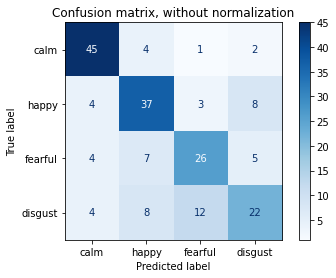

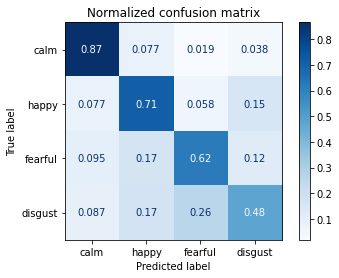

In [ ]:
titles_options = [("Confusion matrix, without normalization", None),("Normalized confusion matrix",'true')]

for title, normalize in titles_options:
  disp = plot_confusion_matrix(model, x_test_reduce, y_test_reduce, display_labels = ['calm', 'happy', 'fearful', 'disgust'], cmap = plt.cm.Blues, normalize = normalize)

  disp.ax_.set_title(title)

  print(title)
  print(disp.confusion_matrix)

plt.show()

# 8. Results and Conclusion

<!DOCTYPE html>
<html>
<head>
<style>
table {
  font-family: arial, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

td, th {
  border: 1px solid #dddddd;
  text-align: left;
  padding: 8px;
}

tr:nth-child(even) {
  background-color: #dddddd;
}
</style>
</head>
<body>

<h2>HTML Table</h2>

<table>
  <tr>
    <th>Model</th>
    <th>Accuracy</th>
    <th>Accuracy (with PCA) </th>
  </tr>
  <tr>
    <td>MLP Classifier</td>
    <td>72.92%</td>
    <td>80.21%</td>
  </tr>
  <tr>
    <td>Gradinet Boosting Classifier</td>
    <td>70.31%</td>
    <td>73.96%</td>
  </tr>
  <tr>
    <td>XGBoost Classifier</td>
    <td>69.79%</td>
    <td>73.96%</td>
  </tr>

</table>

</body>
</html>

Note: The accuracy may vary when we run again.

**Conclusion: MLP Classifier with PCA has the highest accuracy which is up to 80.21%**

# Hyperparameter Tuning for MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint as sp_randint

mlp = MLPClassifier(max_iter=100)

parameter_space = {
    'hidden_layer_sizes': [(sp_randint.rvs(100,600,1),sp_randint.rvs(100,600,1),), 
                                          (sp_randint.rvs(100,600,1),), (100,), (50,50,50), (50,100,50),],
    'activation': ['tanh', 'relu', 'identity', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive', 'invscaling'],
}

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

clf_GS = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3, verbose = 1)
clf_GS = clf_GS.fit(x_train_reduce,y_train_reduce)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  9.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



Confusion matrix, without normalization
[[48  2  1  1]
 [ 5 39  3  5]
 [ 0  4 31  7]
 [ 2  4  8 32]]
Normalized confusion matrix
[[0.92307692 0.03846154 0.01923077 0.01923077]
 [0.09615385 0.75       0.05769231 0.09615385]
 [0.         0.0952381  0.73809524 0.16666667]
 [0.04347826 0.08695652 0.17391304 0.69565217]]


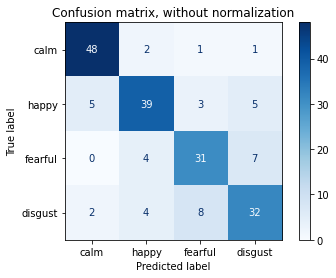

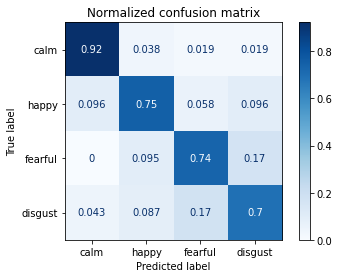

In [ ]:
titles_options = [("Confusion matrix, without normalization", None),("Normalized confusion matrix",'true')]

for title, normalize in titles_options:
  disp = plot_confusion_matrix(clf_GS, x_test_reduce, y_test_reduce, display_labels = ['calm', 'happy', 'fearful', 'disgust'], cmap = plt.cm.Blues, normalize = normalize)

  disp.ax_.set_title(title)

  print(title)
  print(disp.confusion_matrix)

#accuracy=accuracy_score(y_true=y_test_reduce, y_pred=y_pred)
#print("Confusion Matrix:\n",confusion_matrix(y_true=y_test_reduce, y_pred=y_pred))
#print("Accuracy: {:.2f}%".format(accuracy*100))
plt.show()

In [ ]:
y_pred=clf_GS.predict(x_test_reduce)

accuracy=accuracy_score(y_true=y_test_reduce, y_pred=y_pred)
print("Confusion Matrix:\n",confusion_matrix(y_true=y_test_reduce, y_pred=y_pred))
print("Accuracy: {:.2f}%".format(accuracy*100))

Confusion Matrix:
 [[48  2  1  1]
 [ 5 39  3  5]
 [ 0  4 31  7]
 [ 2  4  8 32]]
Accuracy: 78.12%


In [ ]:
new_parameters = clf_GS.best_estimator_.get_params()
new_parameters
# new_MLP = MLPClassifier(new_parameters)

# new_parameters.keys()


{'activation': 'relu',
 'alpha': 0.05,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (193, 101),
 'learning_rate': 'invscaling',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 100,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

# 9. Calculating Area under ROC curve for Hyperparameter Tuning for MLP

In [ ]:
y_prob = clf_GS.predict_proba(x_test_reduce)

macro_roc_auc_ovo = roc_auc_score(y_test_reduce, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test_reduce, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test_reduce, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test_reduce, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.924860 (macro),
0.927010 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.927008 (macro),
0.930041 (weighted by prevalence)
